# [E-11] 어제 오른 내 주식, 과연 내일은?

이번 프로젝트는 ARIMA 시계열 분석법을 배우고, 직접 주식 시세를 예측해 보는 것을 목표로 한다.

<hr>

## 1. 시계열 데이터 준비

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 삼성 주식 데이터(21.02.17~22.02.17)
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-17,83900.0,84200.0,83000.0,83200.0,81707.648438,18307735
2021-02-18,83200.0,83600.0,82100.0,82100.0,80627.375000,21327683
2021-02-19,82300.0,82800.0,81000.0,82600.0,81118.421875,25880879
2021-02-22,83800.0,84200.0,82200.0,82200.0,80725.585938,25419886
2021-02-23,81200.0,82900.0,81100.0,82000.0,80529.171875,20587314


날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있다. 이번 프로젝트에서는 종가(Close)만 사용할 예정이다.

In [3]:
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2021-02-17    83200.0
2021-02-18    82100.0
2021-02-19    82600.0
2021-02-22    82200.0
2021-02-23    82000.0
Name: Close, dtype: float64

<hr>

## 2. 각종 전처리 수행

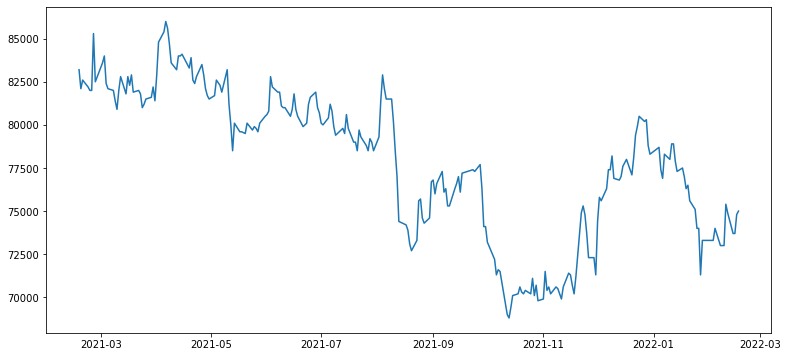

In [4]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기

plt.plot(ts)  # 시계열(time series) 데이터 차트

In [5]:
ts[ts.isna()] # 결측치 확인

Series([], Name: Close, dtype: float64)

Series로 출력된 값이 없는 것으로 보아 결측치가 존재하지 않는다.

<hr>

## 3. 시계열 안정성 분석

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

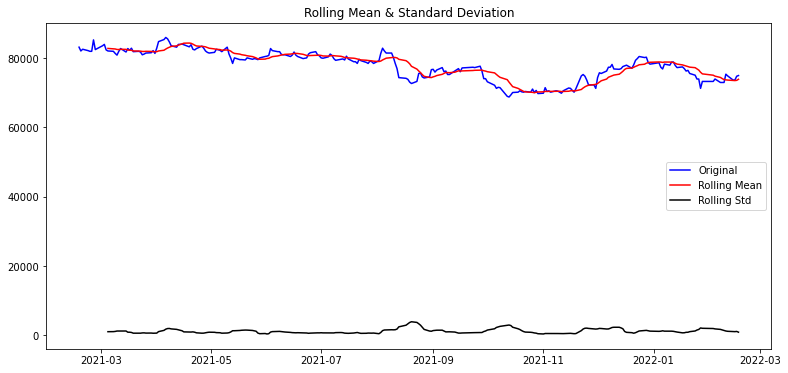

In [7]:
plot_rolling_statistics(ts, window=12)

In [8]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [9]:
augmented_dickey_fuller_test(ts)  # ADF Test

Results of Dickey-Fuller Test:
Test Statistic                  -1.900220
p-value                          0.331958
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


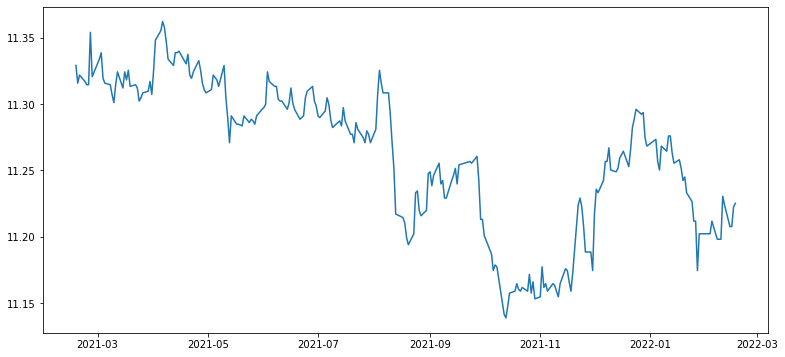

In [10]:
ts_log = np.log(ts)  # 로그함수 변환
plt.plot(ts_log)

In [11]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.889188
p-value                          0.337164
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


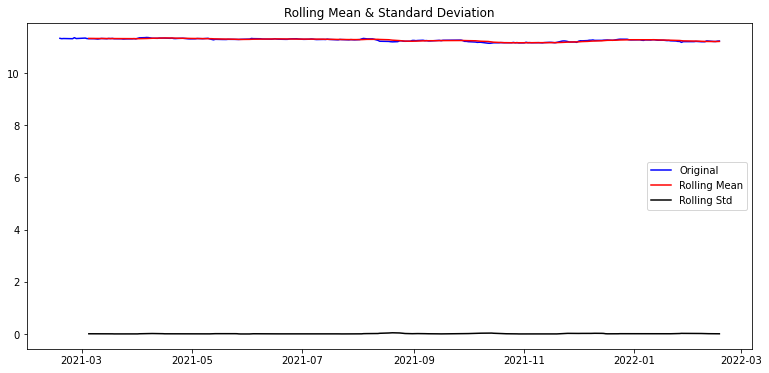

In [12]:
plot_rolling_statistics(ts_log, window=12)

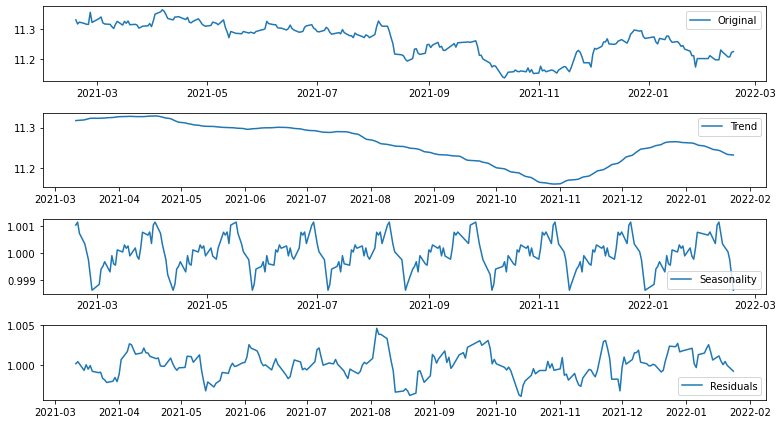

In [13]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

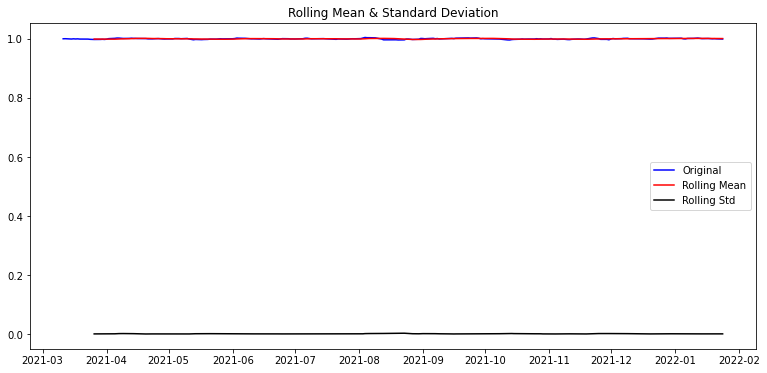

Results of Dickey-Fuller Test:
Test Statistic                  -5.472708
p-value                          0.000002
#Lags Used                       1.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


In [14]:
# 안정성 여부 확인
plt.rcParams["figure.figsize"] = (13,6)  
plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

<hr>

## 4. 학습, 테스트 데이터셋 생성

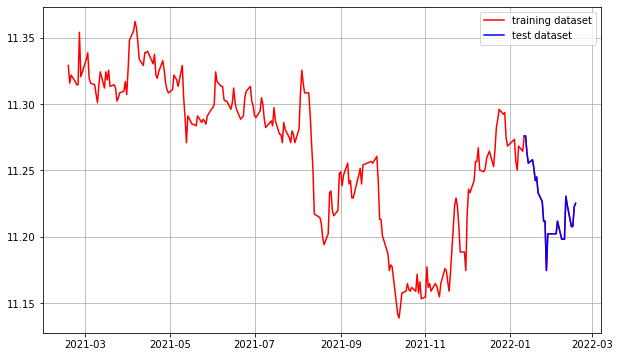

In [15]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

<hr>

## 5. 적정 ARIMA 모수 찾기

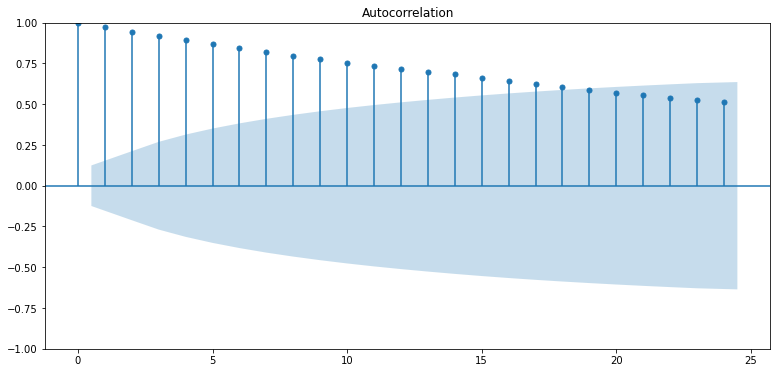

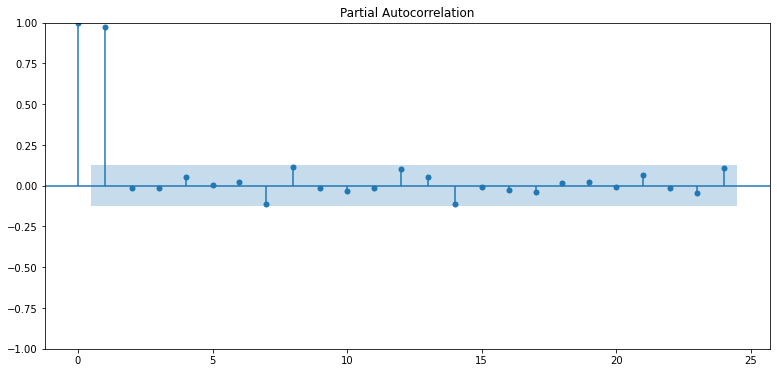

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프
plt.show()

ACF 그래프는 점차 감소하는 추세를 보이고 있고 AR(1) 모델에 유사한 형태를 보인다. PACF 그래프는 p가 1 이후인 지점부터 0에 가깝게 나타나고 있다. 따라서 p=1로 사용하였고 AR의 경향을 가질 수 있도록 MA의 값인 q는 0으로 사용했다.

Results of Dickey-Fuller Test:
Test Statistic                -1.535769e+01
p-value                        3.647987e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.293282e+00
p-value                        4.205271e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


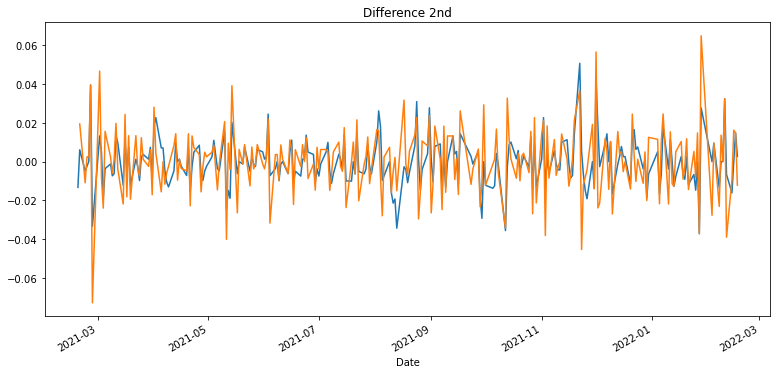

In [17]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

2차 차분까지 진행한 후의 p-value를 확인해보면 차분의 의미가 없어보인다. 따라서 d=1로 설정할 예정이다. <br> (1, 1, 0), (0, 1, 1), (0, 1, 0)으로 모델을 사용해보았더니 (0, 1, 0)의 모델이 가장 적합해보였다.

<hr>

## 6. ARIMA 모델 훈련과 테스트

In [18]:
from statsmodels.tsa.arima.model import ARIMA
# 모델 설계
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 666.683
Date:                Thu, 17 Feb 2022   AIC                          -1331.366
Time:                        22:58:29   BIC                          -1327.963
Sample:                             0   HQIC                         -1329.992
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0001   9.45e-06     15.244      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):                55.98
Prob(Q):                              0.41   Pr

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood opti

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


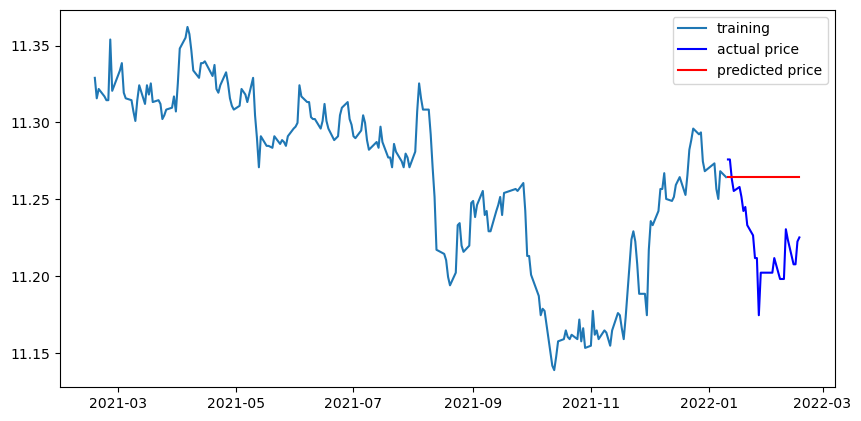

In [19]:
# Forecast : 결과가 fc에 담긴다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  12293600.00000039
MAE:  3048.00000000005
RMSE:  3506.2230391120856
MAPE: 4.12%


<hr>

## 다른 주식 종목 예측

#### 네이버 주식 데이터(21.02.17~22.02.17)

In [21]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035420.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2021-02-17    392000.0
2021-02-18    388000.0
2021-02-19    398000.0
2021-02-22    386500.0
2021-02-23    390500.0
Name: Close, dtype: float64

In [22]:
#결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]

#로그 변환
ts_log = np.log(ts)

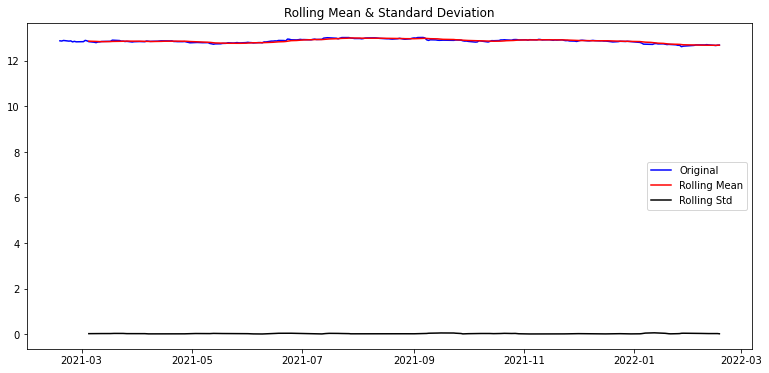

Results of Dickey-Fuller Test:
Test Statistic                  -0.964423
p-value                          0.766018
#Lags Used                       2.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


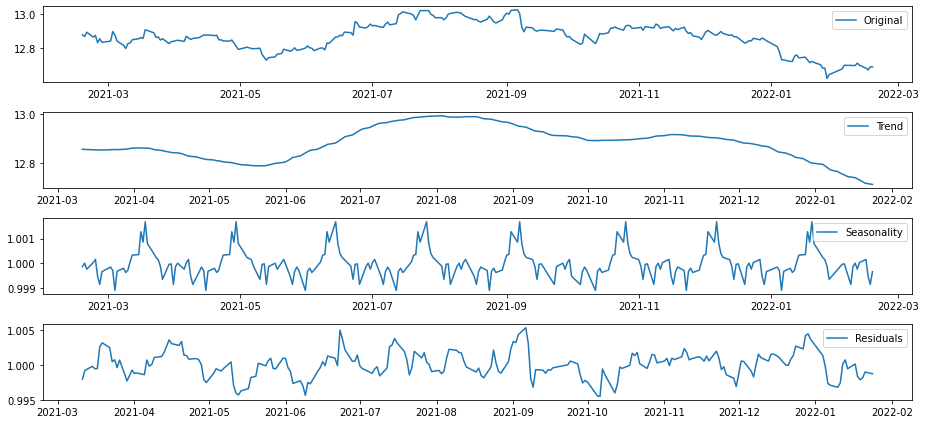

In [23]:
# 정성적 그래프
plot_rolling_statistics(ts_log, window=12)

# Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [24]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.139481e+00
p-value                        8.035904e-08
#Lags Used                     1.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


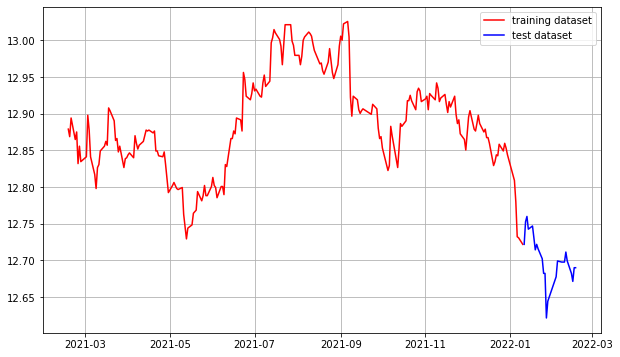

In [25]:
#데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

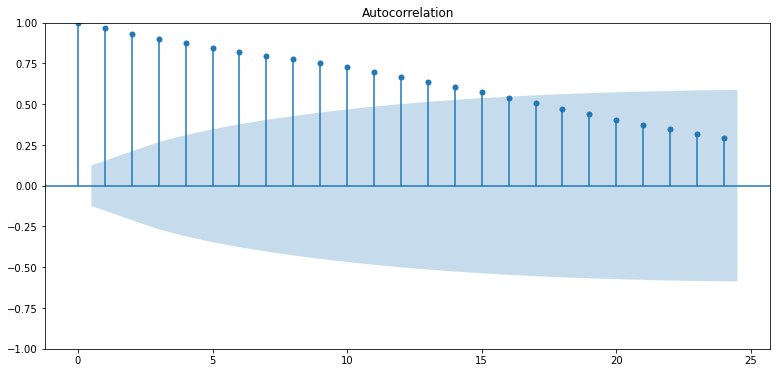

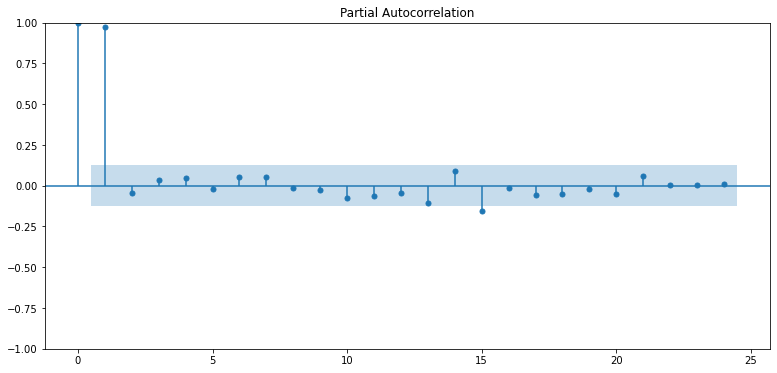

In [26]:
#ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   #ACF : Autocorrelation 그래프
plot_pacf(ts_log)  #PACF : Partial Autocorrelation 그래프
plt.show()

삼성 주식과 마찬가지로 ACF 그래프는 점차 감소하는 추세를 보이고 있고 AR(1) 모델에 유사한 형태를 보인다. PACF 그래프는 p가 1 이후인 지점부터 0에 가깝게 나타나고 있다. 따라서 먼저 p=1로 사용해보았고 AR의 경향을 가질 수 있도록 MA의 값인 q는 0으로 사용해보았다.

Results of Dickey-Fuller Test:
Test Statistic                -1.202367e+01
p-value                        2.983095e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.853831e+00
p-value                        5.510049e-12
#Lags Used                     1.400000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


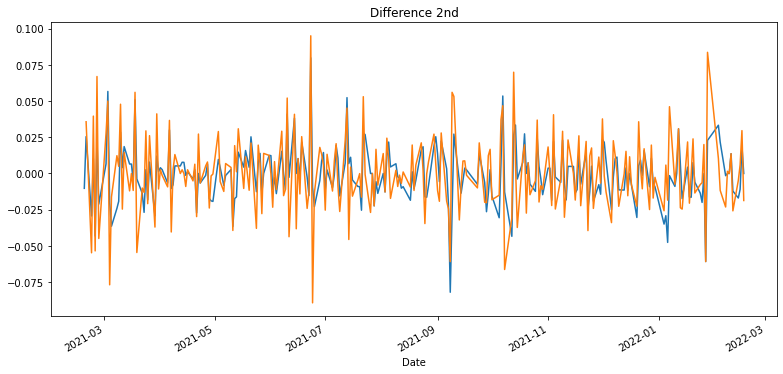

In [27]:
#1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분하였을 때 p-value 값이 줄어든 것을 확인하였다. 따라서 d=1을 사용하기로 하였다. <br>
(1, 1, 0), (0, 1, 1), (0, 1, 0)으로 모델을 사용해보았더니 (0, 1, 0)의 모델이 가장 적합해보였다.

In [28]:
from statsmodels.tsa.arima.model import ARIMA

#Build Model
model = ARIMA(train_data, order=(0, 1, 0))  

fitted_m = model.fit()  
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 565.251
Date:                Thu, 17 Feb 2022   AIC                          -1128.501
Time:                        22:58:30   BIC                          -1125.098
Sample:                             0   HQIC                         -1127.127
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   2.24e-05     16.051      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                69.50
Prob(Q):                              0.66   Pr

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


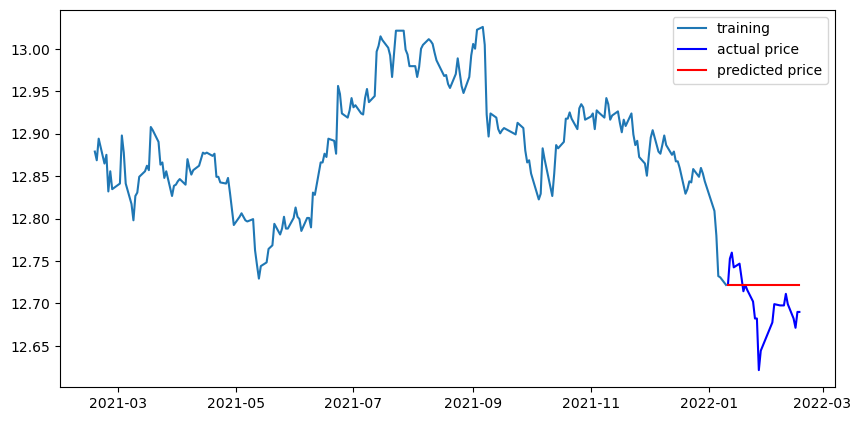

In [29]:
# Forecast : 결과가 fc에 담긴다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [30]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  145509999.99999765
MAE:  9739.999999999907
RMSE:  12062.752588028889
MAPE: 3.02%


<hr>

#### 카카오 주식 데이터 (21.02.17~22.02.17)

In [31]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035720.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2021-02-17    101800.0
2021-02-18    100200.0
2021-02-19    100800.0
2021-02-22     98100.0
2021-02-23     97400.0
Name: Close, dtype: float64

In [32]:
#결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [33]:
#로그 변환
ts_log = np.log(ts)

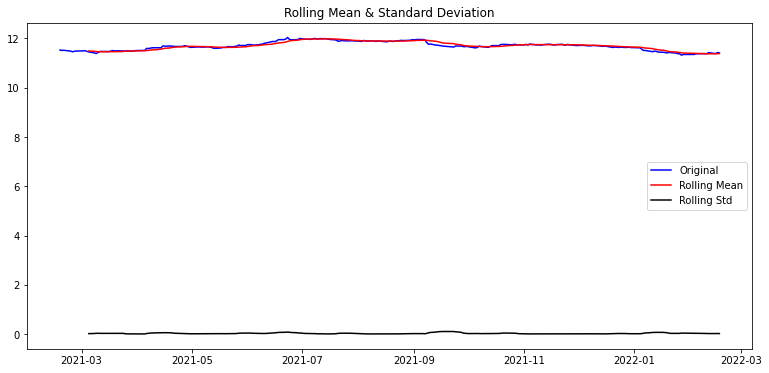

Results of Dickey-Fuller Test:
Test Statistic                  -1.490269
p-value                          0.538320
#Lags Used                       7.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


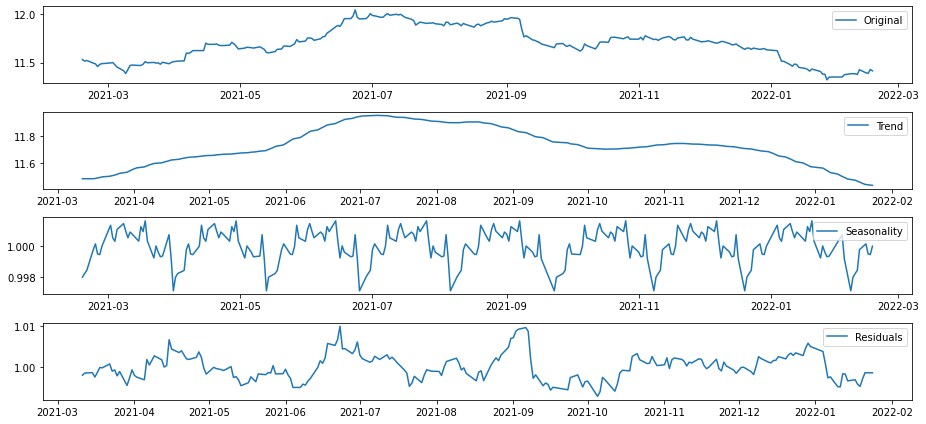

In [34]:
# 정성적 그래프
plot_rolling_statistics(ts_log, window=12)

# Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [35]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.271103
p-value                          0.000498
#Lags Used                       3.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


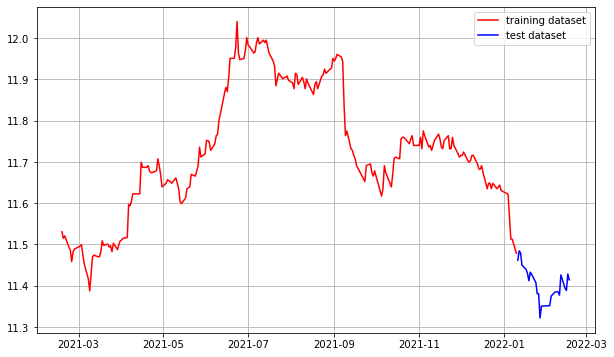

In [36]:
#데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

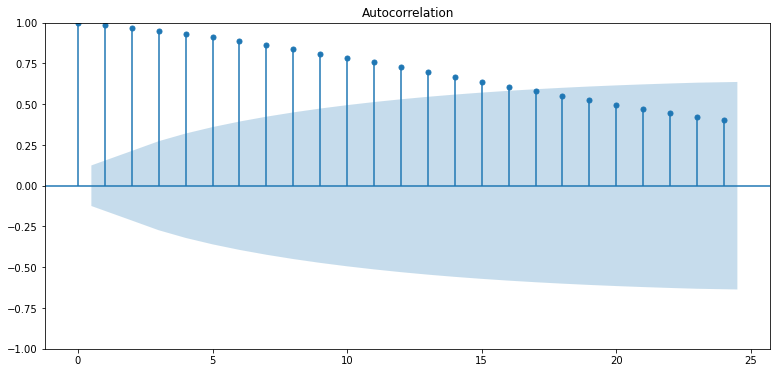

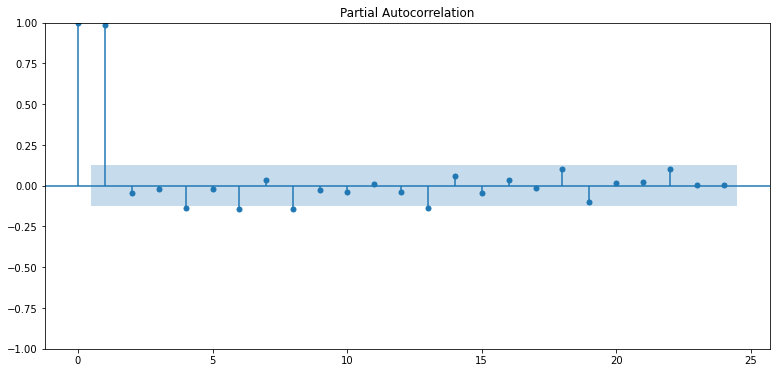

In [37]:
#ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   #ACF : Autocorrelation 그래프
plot_pacf(ts_log)  #PACF : Partial Autocorrelation 그래프
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.893234e+00
p-value                        4.379448e-12
#Lags Used                     2.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.178480e+01
p-value                        1.014775e-21
#Lags Used                     5.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.513526e+00
p-value                        1.150317e-13
#Lags Used                     1.500000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+

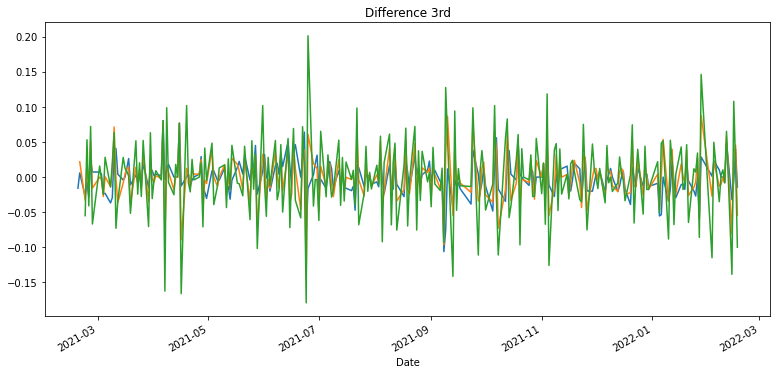

In [38]:
#1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

#3차 차분 구하기
diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3rd')

augmented_dickey_fuller_test(diff_3)

이번에는 2차 차분까지 p-value 값이 줄어드는 것을 확인하였고 따라서 d=2로 사용한 모델들을 실험하였다. <br> p=0,1,2일 때와 q=0,1,2일 때의 경우들을 모두 사용하여 실험해 본 결과, (1,2,2)일 때의 모델이 가장 적합해 보였다.

In [39]:
from statsmodels.tsa.arima.model import ARIMA

#Build Model
model = ARIMA(train_data, order=(1, 2, 2))  

fitted_m = model.fit()  
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(1, 2, 2)   Log Likelihood                 514.453
Date:                Thu, 17 Feb 2022   AIC                          -1020.906
Time:                        22:58:31   BIC                          -1007.313
Sample:                             0   HQIC                         -1015.418
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7587      0.171     -4.438      0.000      -1.094      -0.424
ma.L1         -0.1153      0.148     -0.777      0.437      -0.406       0.176
ma.L2         -0.8161      0.129     -6.317      0.0

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


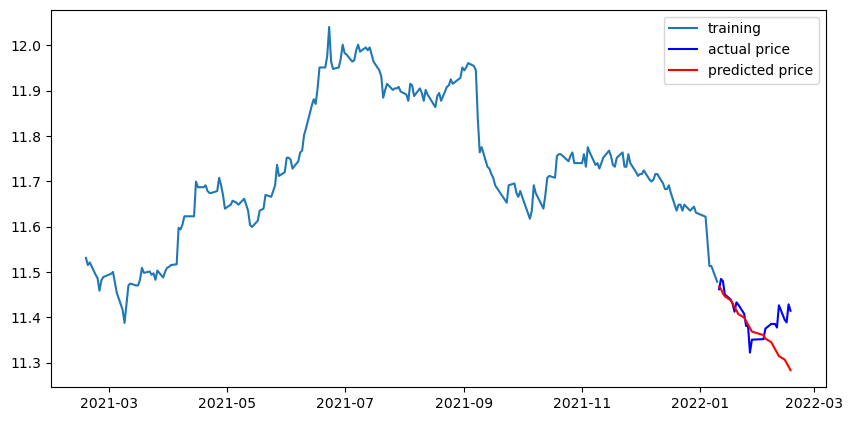

In [40]:
# Forecast : 결과가 fc에 담긴다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [41]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  23700978.070093445
MAE:  3432.257330052509
RMSE:  4868.365030489543
MAPE: 3.83%


<hr>

#### 애플 주식 데이터 (21.02.17~22.02.17)

In [42]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2021-02-17    130.839996
2021-02-18    129.710007
2021-02-19    129.869995
2021-02-22    126.000000
2021-02-23    125.860001
Name: Close, dtype: float64

In [43]:
#결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [44]:
#로그 변환
ts_log = np.log(ts)

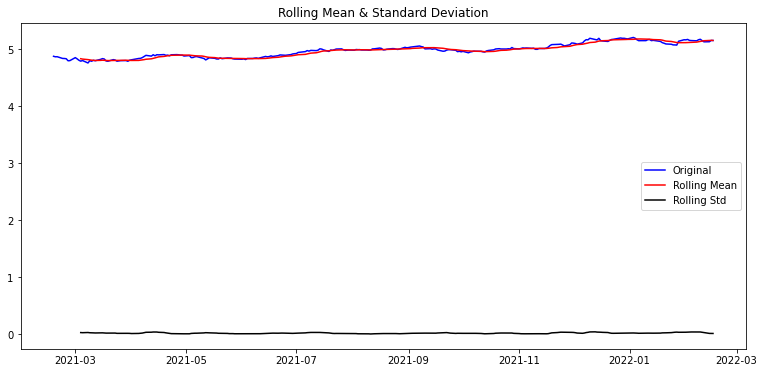

Results of Dickey-Fuller Test:
Test Statistic                  -0.690251
p-value                          0.849259
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


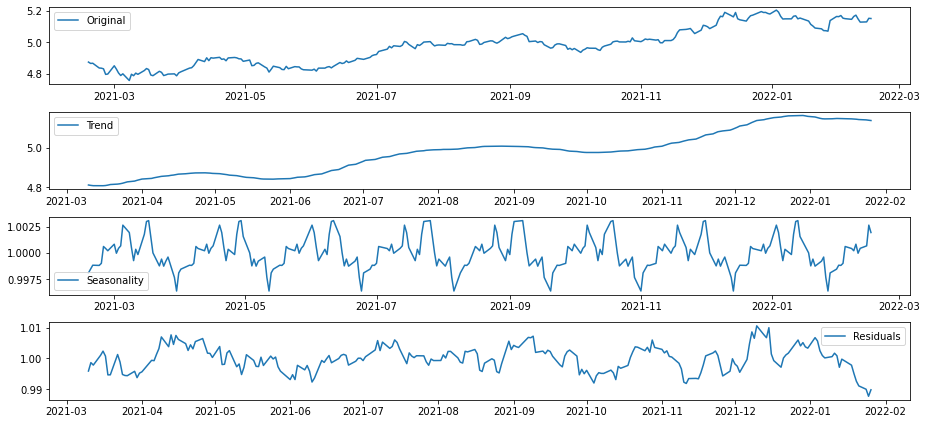

In [45]:
# 정성적 그래프
plot_rolling_statistics(ts_log, window=12)

# Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [46]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.449081
p-value                          0.000243
#Lags Used                       6.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


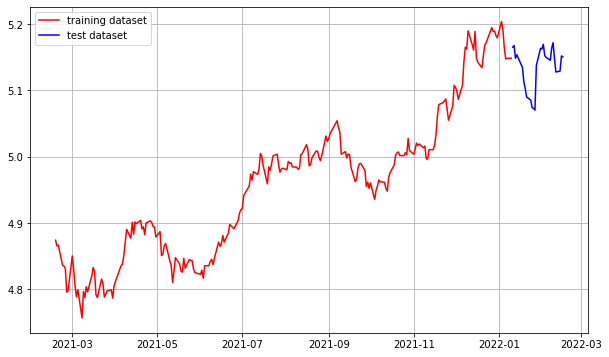

In [47]:
#데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

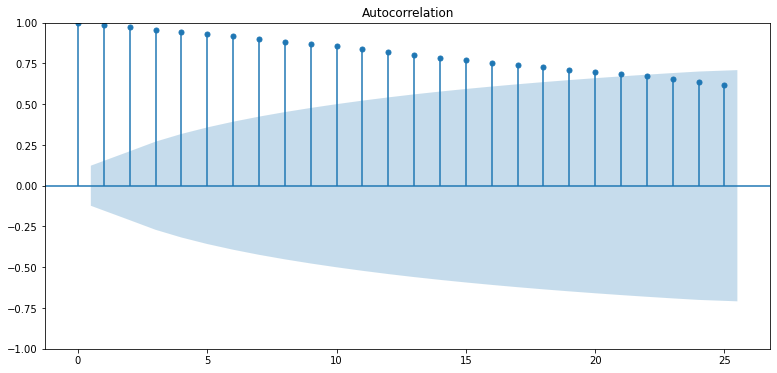

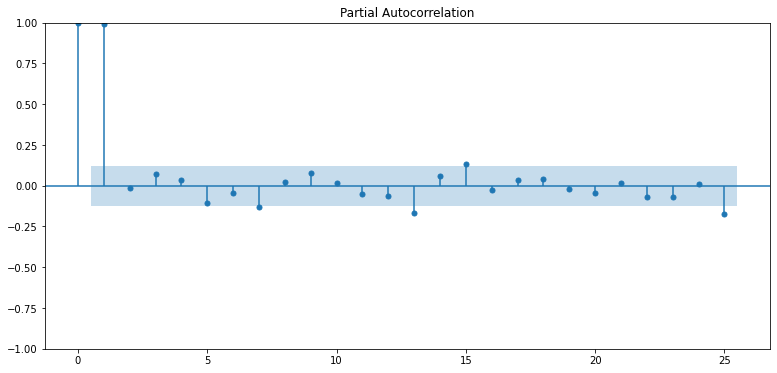

In [48]:
#ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   #ACF : Autocorrelation 그래프
plot_pacf(ts_log)  #PACF : Partial Autocorrelation 그래프
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.613159e+01
p-value                        4.778989e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.700936e+00
p-value                        1.339935e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


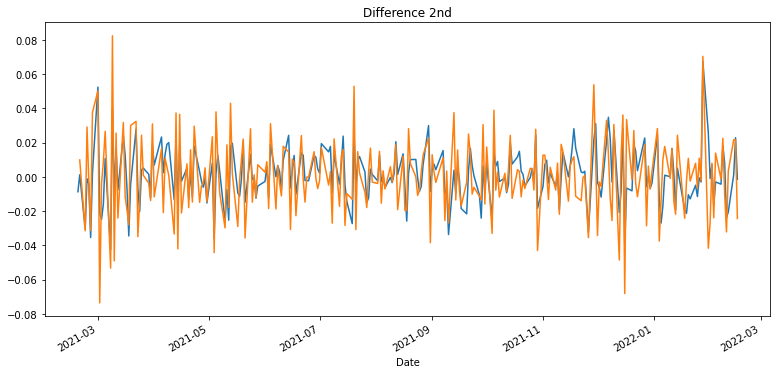

In [49]:
#1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

다른 모델들과 동일한 과정으로 모델을 선정하였고 (0, 1, 0)인 모델을 사용하기로 했다.

In [50]:
from statsmodels.tsa.arima.model import ARIMA

#Build Model
model = ARIMA(train_data, order=(0, 1, 0))  

fitted_m = model.fit()  
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 627.856
Date:                Thu, 17 Feb 2022   AIC                          -1253.712
Time:                        22:58:32   BIC                          -1250.288
Sample:                             0   HQIC                         -1252.330
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   1.98e-05     11.717      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.15   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.28   Pr

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood opti

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


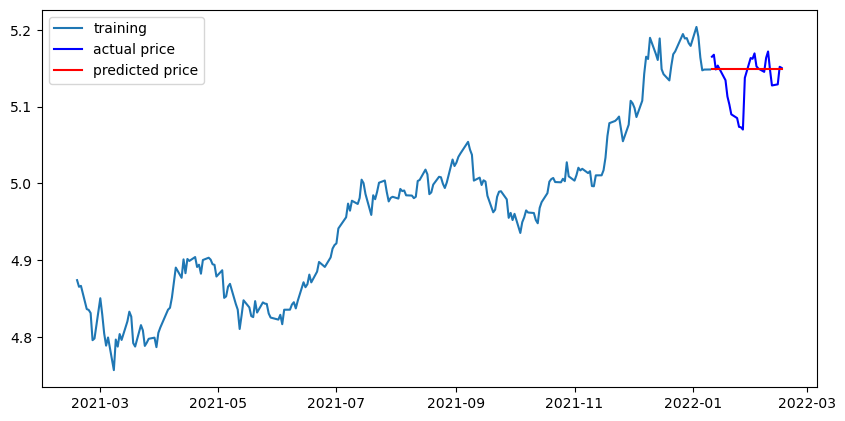

In [51]:
# Forecast : 결과가 fc에 담긴다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [52]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  34.010506200787106
MAE:  4.151922923076906
RMSE:  5.8318527245453575
MAPE: 2.51%


<hr>

#### 테슬라 주식 데이터(21.02.17~22.02.17)

In [53]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2021-02-17    798.150024
2021-02-18    787.380005
2021-02-19    781.299988
2021-02-22    714.500000
2021-02-23    698.840027
Name: Close, dtype: float64

In [54]:
#결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [55]:
#로그 변환
ts_log = np.log(ts)

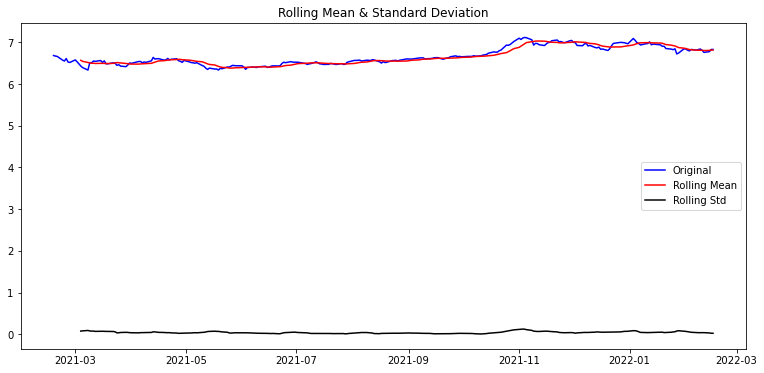

Results of Dickey-Fuller Test:
Test Statistic                  -1.253137
p-value                          0.650330
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


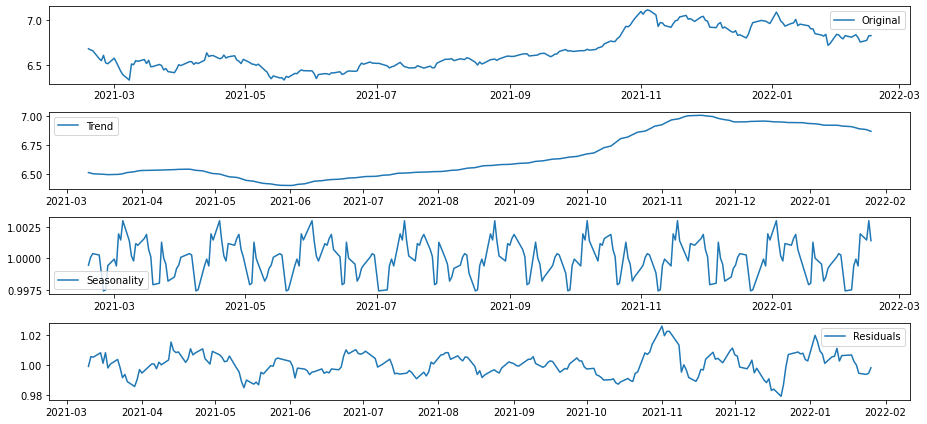

In [56]:
# 정성적 그래프
plot_rolling_statistics(ts_log, window=12)

# Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [57]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.567501e+00
p-value                        8.089813e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


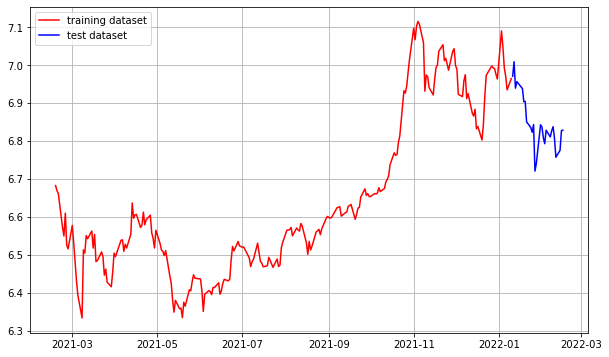

In [58]:
#데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

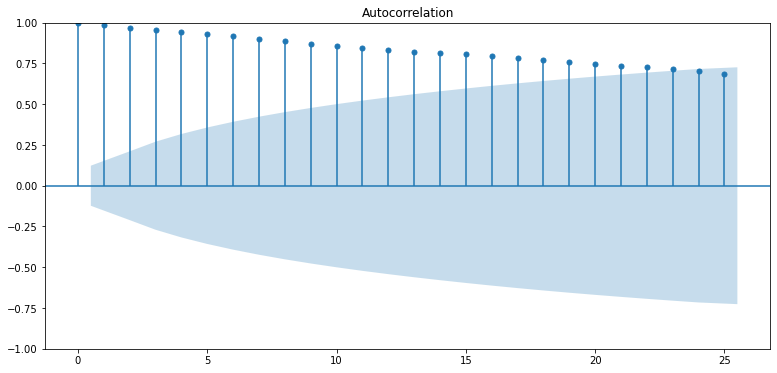

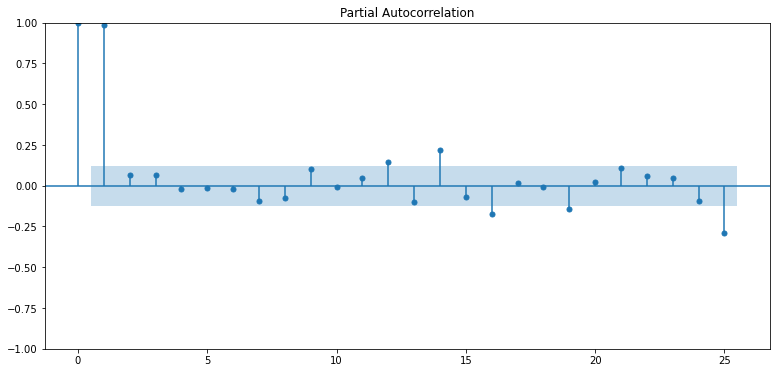

In [59]:
#ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   #ACF : Autocorrelation 그래프
plot_pacf(ts_log)  #PACF : Partial Autocorrelation 그래프
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.683248e+01
p-value                        1.155026e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.198159e+00
p-value                        2.404162e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


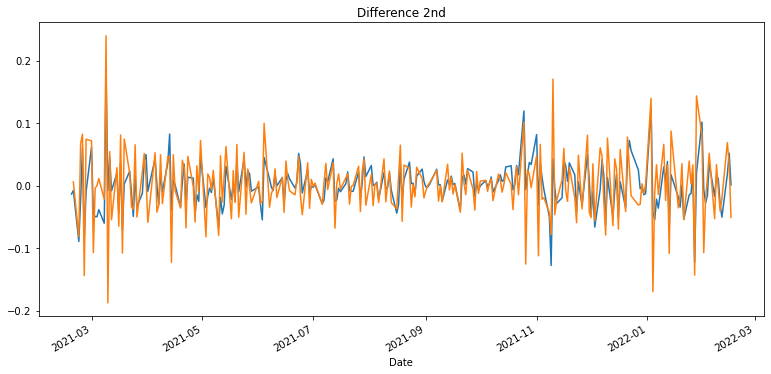

In [60]:
#1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

다른 모델들과 동일한 과정으로 모델을 선정하였고 (0, 1, 0)인 모델을 사용하기로 했다.

In [61]:
model = ARIMA(train_data, order=(0, 1, 0))  

fitted_m = model.fit()  
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 438.744
Date:                Thu, 17 Feb 2022   AIC                           -875.488
Time:                        22:58:33   BIC                           -872.063
Sample:                             0   HQIC                          -874.106
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0012   6.74e-05     18.190      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):               145.55
Prob(Q):                              0.41   Pr

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


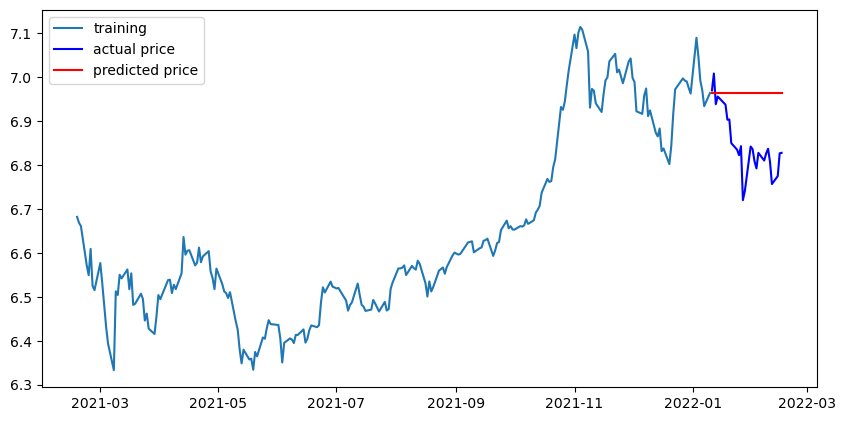

MSE:  17785.63894096211
MAE:  119.42076211538476
RMSE:  133.36280943712197
MAPE: 13.15%


In [62]:
# Forecast : 결과가 fc에 담긴다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

<hr>

#### 비트코인 데이터(21.02.17~22.02.17)

In [63]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/BTC-USD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2021-02-17    52149.007813
2021-02-18    51679.796875
2021-02-19    55888.132813
2021-02-20    56099.519531
2021-02-21    57539.945313
Name: Close, dtype: float64

In [64]:
#결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [65]:
#로그 변환
ts_log = np.log(ts)

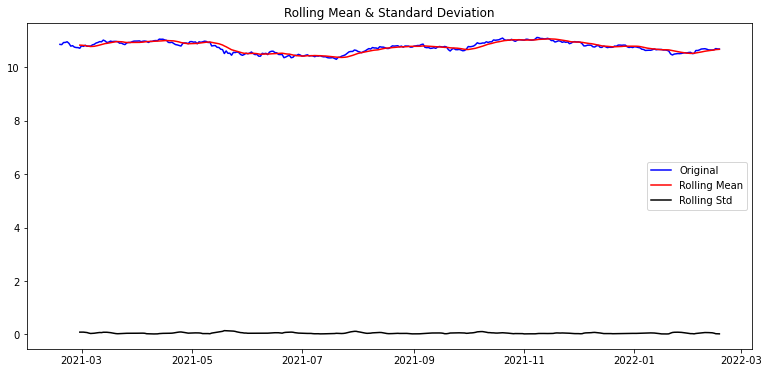

Results of Dickey-Fuller Test:
Test Statistic                  -1.894122
p-value                          0.334831
#Lags Used                       0.000000
Number of Observations Used    365.000000
Critical Value (1%)             -3.448394
Critical Value (5%)             -2.869491
Critical Value (10%)            -2.571006
dtype: float64


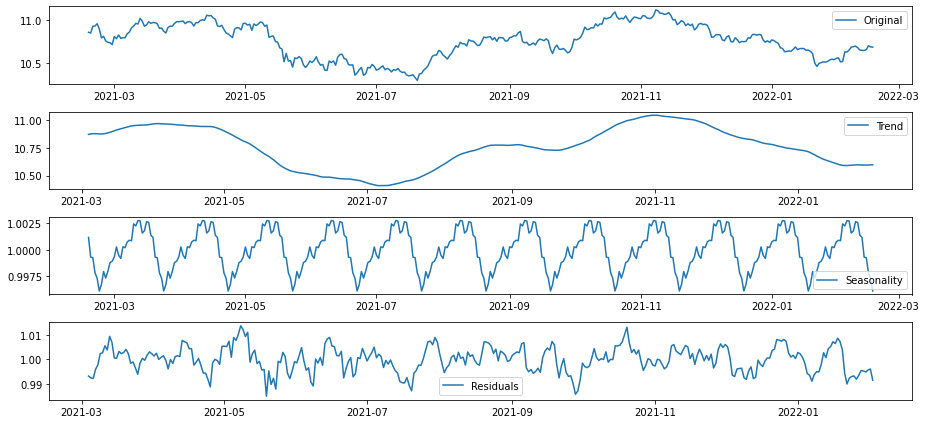

In [66]:
# 정성적 그래프
plot_rolling_statistics(ts_log, window=12)

# Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [67]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.106105e+00
p-value                        9.576416e-08
#Lags Used                     9.000000e+00
Number of Observations Used    3.260000e+02
Critical Value (1%)           -3.450569e+00
Critical Value (5%)           -2.870447e+00
Critical Value (10%)          -2.571515e+00
dtype: float64


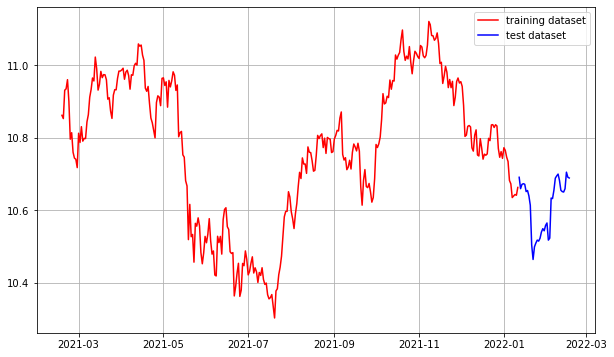

In [68]:
#데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

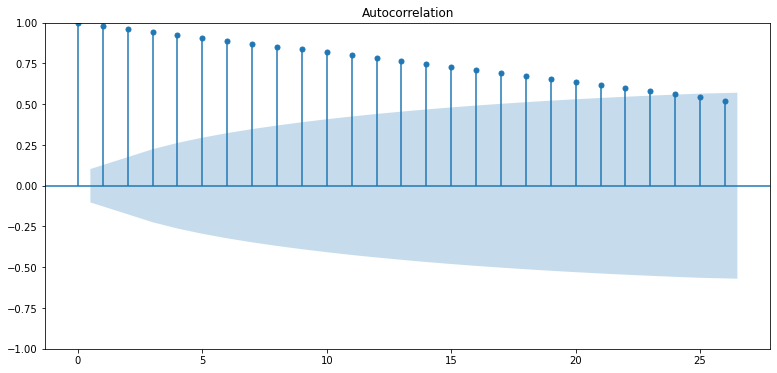

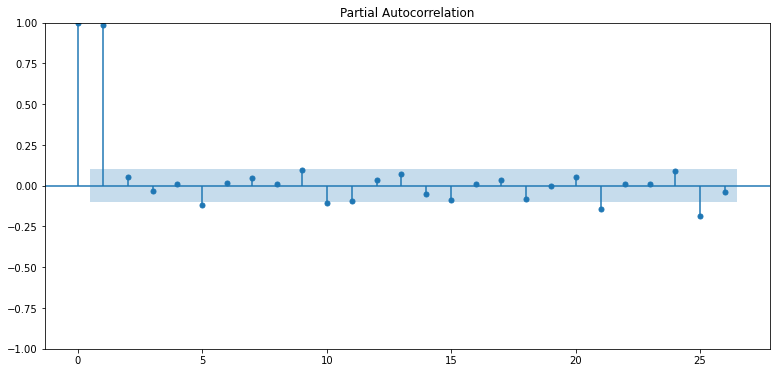

In [69]:
#ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   #ACF : Autocorrelation 그래프
plot_pacf(ts_log)  #PACF : Partial Autocorrelation 그래프
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -20.103047
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.139236e+00
p-value                        2.879328e-15
#Lags Used                     1.200000e+01
Number of Observations Used    3.510000e+02
Critical Value (1%)           -3.449119e+00
Critical Value (5%)           -2.869810e+00
Critical Value (10%)          -2.571176e+00
dtype: float64


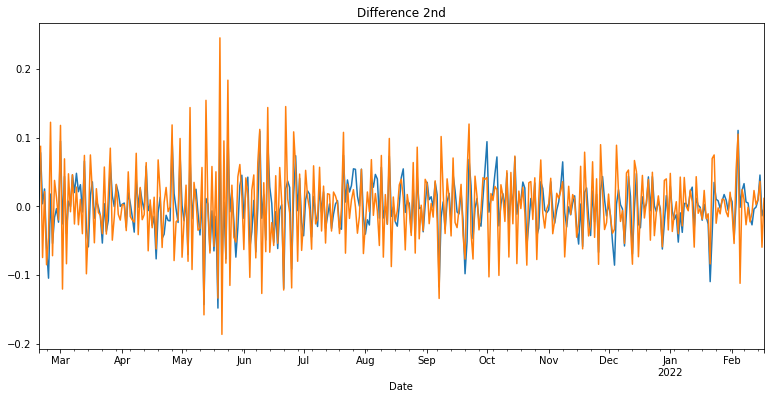

In [70]:
#1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

다른 모델들과 동일한 과정으로 모델을 선정하였고 (0, 1, 0)인 모델을 사용하기로 했다.

In [71]:
model = ARIMA(train_data, order=(0, 1, 0))  

fitted_m = model.fit()  
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  329
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 595.882
Date:                Thu, 17 Feb 2022   AIC                          -1189.764
Time:                        22:58:34   BIC                          -1185.971
Sample:                    02-17-2021   HQIC                         -1188.251
                         - 01-11-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0015   9.47e-05     16.327      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   1.79   Jarque-Bera (JB):                24.81
Prob(Q):                              0.18   Pr

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


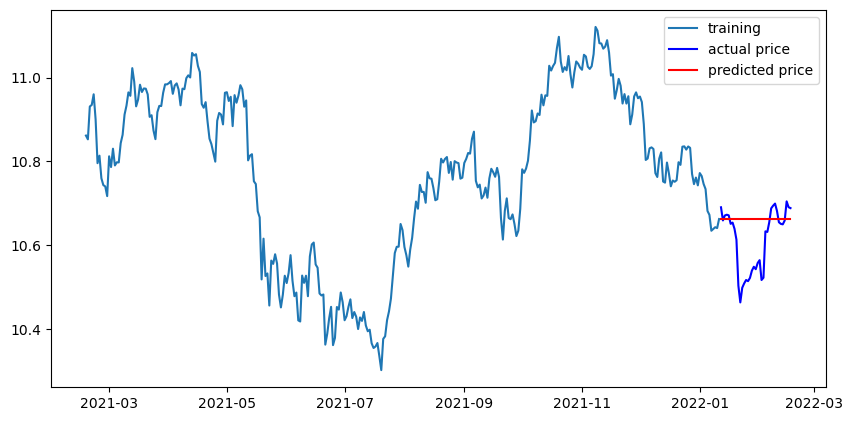

MSE:  12660060.110078843
MAE:  2639.7370143783883
RMSE:  3558.0978218816363
MAPE: 6.93%


In [72]:
# Forecast : 결과가 fc에 담긴다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

<hr>

## 프로젝트를 마치며

이번 프로젝트는 시계열 데이터를 ARIMA를 활용하여 예측해보는 것이 목적이었다. 시계열 안정성을 먼저 분석하고 모델마다 적절한 ARIMA 모수를 찾는 과정으로 진행하였다. 차분하여 나온 p-value 값을 고정 값으로 두어 p와 q 값을 바꿔가며 적절한 모수를 찾았다. 노드에서는 p와 q의 곱이 0이 되는 모수를 주로 사용한다고 나와 있지만 더 적합하다고 생각되는 모수들이 발견되었을 경우에는 그것들을 사용하였다.

데이터는 삼성, 네이버, 카카오, 애플, 테슬라, 비트코인의 시세를 나타낸 데이터를 활용하였다. 정리한 결과는 다음과 같다.

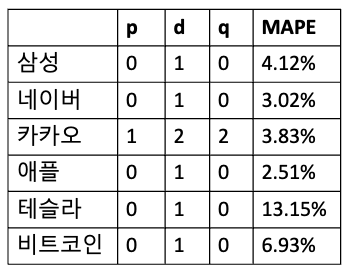

ARIMA 모수는 카카오를 제외한 모든 종목들이 동일하게 (0, 1, 0)이 가장 적합했고 카카오는 (1, 2, 2)가 가장 적합했다. MAPE는 모두 목표치인 15% 미만을 달성하였고 13.15%인 테슬라의 MAPE가 가장 높게 나왔다.

결과물이 잘 예측된 모델인지 사실 잘 모르겠다. 시계열의 개념에 대한 이해가 필요한 작업이었기에 조금 어렵게 느껴졌다. 전체적인 과정에서 훈련에 적합하지 못한 부분을 알아차리지 못하고 지나쳤을 수도 있고 잘못된 결과이지만 우연히 목표 MAPE 값에 도달한 것일지도 모른다. 아마 현업에서 시계열 데이터를 예측할 때는 다른 외부 요인들도 많이 고려할 것 같은데 더 깊게 공부해서 외부 요인을 고려한 모델을 만들어보고 싶다. 학교에서 시계열 분석 강의를 듣지 않았던 것을 매우 후회하게 한 프로젝트였다. 다양한 분야에서 시계열 데이터가 사용되고 있을 것 같은데 나중에 시계열 관련 강의를 들어보는 것도 나쁘지 않을 것 같다는 생각이 들었다.